The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


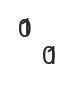

In [76]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import dataframe_image as dfi
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
f,a = plt.subplots(1,1,figsize=(1e-2, 1e-2))
mpl.rcParams['figure.dpi'] = 180
sns.set_style('darkgrid')
import os,sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import warnings
warnings.filterwarnings("ignore")

from tqdm.auto import tqdm
from datetime import datetime as dt
from src.utils import mkdirs, convert_path, pkl_dump, pkl_load, display_side, add_median_labels, get_palette
from src.data_processing import BL62_VALUES, BL62FREQ_VALUES, HLAS, AA_KEYS
from src.metrics import get_nested_feature_importance, plot_feature_importance
from src.models import Standardizer, NNAlign
from src.utils import pkl_load, pkl_dump, get_palette
from src.bootstrap import bootstrap_eval, get_pval, plot_pval
from src.bootstrap import get_pval, plot_pval
from src.datasets import NNAlignDataset, get_NNAlign_dataloader
import torch
from torch import nn
from torch.nn import functional as F
from torch import optim
mpl.rcParams['figure.dpi'] = 180

In [3]:
cedar_aligned = pd.read_csv('../data/aligned_icore/230418_cedar_aligned.csv')
prime_aligned = pd.read_csv('../data/aligned_icore/230418_prime_aligned.csv')
viral = pd.read_csv('../data/other/viral.csv').rename(columns={'sequence':'Peptide'})
drb = pd.read_csv('../data/NetMHCIIpan_train/drb1_0301.csv')

# check dataset / extra features behaviour

In [11]:
from src.datasets import get_NNAlign_dataloader, NNAlignDataset
loader, dataset = get_NNAlign_dataloader(cedar_aligned, max_len=12, window_size=6, encoding='BL50LO', 
                                        seq_col='Peptide', target_col='agg_label', pad_scale=-15, return_dataset=True, 
                                        feature_cols = ['EL_rank_mut', 'icore_dissimilarity_score'])

In [21]:
from src.models import NNAlign
# Taking a sample and testing some stuff
xd, xd_mask, _, _ = dataset[50:100]
x_tensor, x_mask, x_features, y_true = dataset[:10]
mymodel = NNAlign(30, 6)
mymodel.fit_standardizer(xd, xd_mask)
z = mymodel(x_tensor, x_mask)

In [23]:
x_features.shape, z.shape

(torch.Size([10, 2]), torch.Size([10, 1]))

In [29]:
torch.cat([z, x_features], dim=1).shape

torch.Size([10, 3])

# Rearrange data

In [52]:
cedar_aligned = pd.read_csv('../data/aligned_icore/230418_cedar_aligned.csv')
prime_aligned = pd.read_csv('../data/aligned_icore/230418_prime_aligned.csv')
nepdb_aligned = pd.read_csv('../data/aligned_icore/230418_nepdb_aligned.csv')

In [53]:
rename_cols = {'Peptide':'mutant', 'agg_label':'target', 'icore_dissimilarity_score':'icore_selfsimilarity'}
cols_ = list(filter(lambda x: 'mixed' not in x and 'improves' not in x.lower() and 'Unnamed' not in x and 'fullpep_vs_icore_rank' not in x, cedar_aligned.columns))
cols_

['HLA',
 'agg_label',
 'fold',
 'Peptide',
 'wild_type',
 'icore_mut',
 'core_mut',
 'len',
 'EL_rank_mut',
 'EL_rank_wt',
 'trueHLA_EL_rank',
 'icore_mut_start',
 'len_icore_mut',
 'icore_wt_aligned',
 'icore_dissimilarity_score',
 'icore_len_mut',
 'icore_len_wt',
 'icore_anchor',
 'icore_mutation_position',
 'icore_anchor_mutation',
 'icore_mut_score',
 'icore_blsm_mut_score',
 'aliphatic_index',
 'boman',
 'hydrophobicity',
 'isoelectric_point',
 'VHSE1',
 'VHSE3',
 'VHSE7',
 'VHSE8',
 'seq_id',
 'core_wt_aligned',
 'EL_rank_wt_aligned',
 'ratio_rank',
 'foreignness_score',
 'expanded_input']

In [54]:
cedar_aligned[cols_].rename(columns = rename_cols).to_csv('../data/aligned_icore/230530_cedar_aligned.csv', index=False)
prime_aligned[cols_].rename(columns = rename_cols).to_csv('../data/aligned_icore/230530_prime_aligned.csv', index=False)
nepdb_aligned[[x for x in cols_ if x!='fold']].rename(columns = rename_cols).to_csv('../data/aligned_icore/230530_nepdb_aligned.csv', index=False)

In [55]:
cedar_expr = pd.read_csv('../data/pepx/230418_cedar_aligned_pepx.csv')
prime_expr = pd.read_csv('../data/pepx/230418_prime_aligned_pepx.csv')
nepdb_expr = pd.read_csv('../data/pepx/230418_nepdb_aligned_pepx.csv')
cols_ = list(filter(lambda x: 'ic_len' not in x and  'mixed' not in x and 'improves' not in x.lower() and 'Unnamed' not in x and 'impr_' not in x and 'fullpep_vs_icore_rank' not in x, cedar_expr.columns))
cedar_expr[cols_].rename(columns=rename_cols).to_csv('../data/pepx/230530_cedar_expr.csv', index=False)
prime_expr[cols_].rename(columns=rename_cols).to_csv('../data/pepx/230530_prime_expr.csv', index=False)
nepdb_expr[[x for x in cols_ if x!='fold']].rename(columns=rename_cols).to_csv('../data/pepx/230530_nepdb_expr.csv', index=False)

In [57]:
list(filter(lambda x: 'sim' in x, cedar_expr.rename(columns=rename_cols).columns))

['icore_selfsimilarity']

In [100]:
cedar_aligned = pd.read_csv('../data/aligned_icore/230530_cedar_aligned.csv')
ef_loader, ef_dataset = get_NNAlign_dataloader(cedar_aligned, max_len=12, window_size=5, seq_col='mutant',
                                               target_col='target', feature_cols = ['EL_rank_mut'], return_dataset=True)
for data in ef_loader:
    x1_tensor, x1_mask, x1_feat, y1 = data
    print(type(data), len(data), type(data[0]), len(data[0]), ef_dataset.extra_features_flag)
    break
    
nr_loader, nr_dataset = get_NNAlign_dataloader(cedar_aligned, max_len=12, window_size=5, seq_col='mutant',
                                               target_col='target', return_dataset=True)
for data in nr_loader:
    x2_tensor, x2_mask, y2 = data
    print(type(data), len(data), type(data[0]), len(data[0]), nr_dataset.extra_features_flag)
    break

<class 'list'> 4 <class 'torch.Tensor'> 64 True
<class 'list'> 3 <class 'torch.Tensor'> 64 False


In [87]:
from src.models import NNAlignEF, NNAlign
from src.datasets import get_NNAlign_dataloader, NNAlignDataset
from src.train_eval import train_model_step, eval_model_step, predict_model
cedar_aligned = pd.read_csv('../data/aligned_icore/230530_cedar_aligned.csv')
n_hidden=25
window_size=5
dropout=0.15
batchnorm=True
feature_cols = ['EL_rank_mut', 'icore_selfsimilarity']
n_extrafeatures= len(feature_cols)
activation = nn.ReLU()
indel, standardize = False, True

# With extra col
train_loader, train_dataset = get_NNAlign_dataloader(cedar_aligned.query('fold!=0 and fold != 1'), max_len=12, window_size=5, 
                                                     seq_col='mutant', target_col='target',
                                                     feature_cols = feature_cols, return_dataset=True)
valid_loader, valid_dataset = get_NNAlign_dataloader(cedar_aligned.query('fold==0'), max_len=12, window_size=5, 
                                                     seq_col='mutant', target_col='target',
                                                     feature_cols = feature_cols, return_dataset=True)
test_loader, test_dataset = get_NNAlign_dataloader(cedar_aligned.query('fold==1'), max_len=12, window_size=5, 
                                                   seq_col='mutant', target_col='target',
                                                     feature_cols = feature_cols, return_dataset=True)

model = NNAlignEF(n_hidden, window_size, activation, batchnorm, dropout, indel, standardize, 
                  n_extrafeatures, n_hidden, activation, batchnorm, dropout)

model.fit_standardizer(x_tensor=train_dataset.x_tensor, x_mask=train_dataset.x_mask, x_features=train_dataset.x_features)

criterion = nn.BCEWithLogitsLoss(reduction='mean')
optimizer = optim.SGD(model.parameters(), lr=1e-4, weight_decay=1e-2)
train_stuff = train_model_step(model, criterion, optimizer, train_loader)
valid_stuff = eval_model_step(model, criterion, valid_loader)
predict_stuff = predict_model(model, test_dataset)

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Users/riwa/opt/anaconda3/envs/phd/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3398, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/62/pqfhzdzx689fgftqcgjrgbcw0000gp/T/ipykernel_34921/3968390749.py", line 31, in <cell line: 31>
    train_stuff = train_model_step(model, criterion, optimizer, train_loader)
  File "/Users/riwa/Documents/code/PyNNalign/src/train_eval.py", line 100, in train_model_step
    output = model(*data)
  File "/Users/riwa/opt/anaconda3/envs/phd/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1130, in _call_impl
    return forward_call(*input, **kwargs)
  File "/Users/riwa/Documents/code/PyNNalign/src/models.py", line 436, in forward
    z = self.ef_inlayer(z)
  File "/Users/riwa/opt/anaconda3/envs/phd/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1130, in _call_impl
    return forward_call(*input, **kwargs)
  File "/Users/riwa/

In [83]:
x_features = train_dataset[:100][2]
x_features.shape

torch.Size([100, 2])

In [86]:
x_features.mean(dim=0)

tensor([1.7635, 0.9495])

In [94]:
type(train_loader.sampler) == torch.utils.data.RandomSampler

True

# Some manual tuning / exploration with hyperparams now that everything works

In [151]:
cedar_aligned = pd.read_csv('../data/aligned_icore/230530_cedar_aligned.csv')
prime_aligned = pd.read_csv('../data/aligned_icore/230530_prime_aligned.csv')

## Reloading results from simple 10fold kcv script no EF vs EF

In [129]:
from sklearn.metrics import roc_auc_score
PATH = '../output/230530_EF_COMPARISON/'
# No Extra feature
dirs = list(filter(lambda x: 'NO_EF' in x, os.listdir(PATH)))
no_efs=[]
for i,dnms in enumerate(dirs):
    bn_preds = pd.read_csv(f"{PATH}{dnms}/{list(filter(lambda x: 'valid_pred' in x, os.listdir(f'{PATH}{dnms}')))[0]}")
    no_efs.append(bn_preds)

no_efs= pd.concat(no_efs)

# With %Rank
dirs = list(filter(lambda x: 'WITH_EF' in x, os.listdir(PATH)))
with_efs=[]
for i,dnms in enumerate(dirs):
    bn_preds = pd.read_csv(f"{PATH}{dnms}/{list(filter(lambda x: 'valid_pred' in x, os.listdir(f'{PATH}{dnms}')))[0]}")
    with_efs.append(bn_preds)

with_efs= pd.concat(with_efs)
print(f"Base NNAlign:\tAUC={roc_auc_score(no_efs['target'], no_efs['pred']):.7f}\nNNAlign+Rank:\tAUC={roc_auc_score(with_efs['target'],with_efs['pred']):.7f}")

Base NNAlign:	AUC=0.6141508
NNAlign+Rank:	AUC=0.6610781


In [131]:
with_efs.query('target==1')['motif'].to_csv(f'{PATH}motif_with_EF.txt',index=False,header=False)
no_efs.query('target==1')['motif'].to_csv(f'{PATH}motif_no_EF.txt',index=False,header=False)

## Other

In [ ]:
from src.models import NNAlignEF, NNAlign
from src.datasets import get_NNAlign_dataloader, NNAlignDataset
from src.train_eval import train_model_step, eval_model_step, predict_model, train_eval_loops
cedar_aligned = pd.read_csv('../data/aligned_icore/230530_cedar_aligned.csv')
n_hidden=25
n_hidden_ef=5
window_size=5
dropout=0.15
batchnorm=True
feature_cols = ['EL_rank_mut', 'icore_selfsimilarity']
n_extrafeatures= len(feature_cols)
activation = nn.ReLU()
indel, standardize = False, True



for f in sorted(cedar_aligned.fold.unique()): 
    # With extra col
    train_loader, train_dataset = get_NNAlign_dataloader(cedar_aligned.query('fold!=@f'), max_len=12, window_size=5, 
                                                         seq_col='mutant', target_col='target',
                                                         feature_cols = feature_cols, return_dataset=True)
    valid_loader, valid_dataset = get_NNAlign_dataloader(cedar_aligned.query('fold==@f'), max_len=12, window_size=5, 
                                                         seq_col='mutant', target_col='target',
                                                         feature_cols = feature_cols, return_dataset=True)
    
    model = NNAlignEF(n_hidden, window_size, activation, batchnorm, dropout, indel, standardize, 
                      n_extrafeatures, n_hidden_ef, activation, batchnorm, dropout_ef=0.0)
    
    model.fit_standardizer(x_tensor=train_dataset.x_tensor, x_mask=train_dataset.x_mask, x_features=train_dataset.x_features)

In [104]:
xs_ef = ef_dataset[:][:-1]
y_ef = ef_dataset[:][-1]
xs_nr = nr_dataset[:][:-1]
y_nr = nr_dataset[:][-1]


In [103]:
len(xs_nr), len(xs_ef)

(2, 3)

In [107]:
all(y_ef==y_nr)

True

In [132]:
nn.Dropout(0.5).p

0.5

In [137]:
from src.models import NNAlignEF, NNAlign
{'a':NNAlignEF, 'b':NNAlign}['a'](1,5)

NNAlignEF(
  (nnalign_model): NNAlign(
    (nnalign): NNAlignSinglePass(
      (in_layer): Linear(in_features=100, out_features=1, bias=True)
      (out_layer): Linear(in_features=1, out_features=1, bias=True)
      (dropout): Dropout(p=0.0, inplace=False)
      (act): SELU()
    )
    (standardizer): StandardizerSequence()
  )
  (ef_standardizer): StandardizerFeatures()
  (ef_inlayer): Linear(in_features=1, out_features=5, bias=True)
  (ef_outlayer): Linear(in_features=5, out_features=1, bias=True)
  (ef_act): SELU()
  (ef_dropout): Dropout(p=0.0, inplace=False)
)

# Testing single vs double

In [149]:
from sklearn.metrics import roc_auc_score
PATH = '../output/230531_EF_TEST/'
# No Extra feature
dirs = list(filter(lambda x: 'SINGLE' in x, os.listdir(PATH)))
single_ef=[]
for i,dnms in enumerate(dirs):
    bn_preds = pd.read_csv(f"{PATH}{dnms}/{list(filter(lambda x: 'valid_pred' in x, os.listdir(f'{PATH}{dnms}')))[0]}")
    single_ef.append(bn_preds)

single_ef= pd.concat(single_ef)

# With %Rank
dirs = list(filter(lambda x: 'DOUBLE' in x, os.listdir(PATH)))
double_ef=[]
for i,dnms in enumerate(dirs):
    bn_preds = pd.read_csv(f"{PATH}{dnms}/{list(filter(lambda x: 'valid_pred' in x, os.listdir(f'{PATH}{dnms}')))[0]}")
    double_ef.append(bn_preds)

double_ef= pd.concat(double_ef)
print(f"single:\tAUC={roc_auc_score(single_ef['target'], single_ef['pred']):.7f}\ndouble:\tAUC={roc_auc_score(double_ef['target'],double_ef['pred']):.7f}")

single:	AUC=0.6468520
double:	AUC=0.6610781


In [154]:
x='mutant'
len(prime_aligned.query(f'{x} not in @cedar_aligned.{x}.values')), len(prime_aligned)

(2706, 3109)

In [157]:
prime_aligned.columns

Index(['HLA', 'target', 'fold', 'mutant', 'wild_type', 'icore_mut', 'core_mut',
       'len', 'EL_rank_mut', 'EL_rank_wt', 'trueHLA_EL_rank',
       'icore_mut_start', 'len_icore_mut', 'icore_wt_aligned',
       'icore_selfsimilarity', 'icore_len_mut', 'icore_len_wt', 'icore_anchor',
       'icore_mutation_position', 'icore_anchor_mutation', 'icore_mut_score',
       'icore_blsm_mut_score', 'aliphatic_index', 'boman', 'hydrophobicity',
       'isoelectric_point', 'VHSE1', 'VHSE3', 'VHSE7', 'VHSE8', 'seq_id',
       'core_wt_aligned', 'EL_rank_wt_aligned', 'ratio_rank',
       'foreignness_score', 'expanded_input'],
      dtype='object')

In [156]:
cedar_aligned.columns

Index(['HLA', 'target', 'fold', 'mutant', 'wild_type', 'icore_mut', 'core_mut',
       'len', 'EL_rank_mut', 'EL_rank_wt', 'trueHLA_EL_rank',
       'icore_mut_start', 'len_icore_mut', 'icore_wt_aligned',
       'icore_selfsimilarity', 'icore_len_mut', 'icore_len_wt', 'icore_anchor',
       'icore_mutation_position', 'icore_anchor_mutation', 'icore_mut_score',
       'icore_blsm_mut_score', 'aliphatic_index', 'boman', 'hydrophobicity',
       'isoelectric_point', 'VHSE1', 'VHSE3', 'VHSE7', 'VHSE8', 'seq_id',
       'core_wt_aligned', 'EL_rank_wt_aligned', 'ratio_rank',
       'foreignness_score', 'expanded_input'],
      dtype='object')

In [155]:
cedar_aligned.query('fold==2 or fold ==5').isna().any()

HLA                        False
target                     False
fold                       False
mutant                     False
wild_type                  False
icore_mut                  False
core_mut                   False
len                        False
EL_rank_mut                False
EL_rank_wt                 False
trueHLA_EL_rank            False
icore_mut_start            False
len_icore_mut              False
icore_wt_aligned           False
icore_selfsimilarity       False
icore_len_mut              False
icore_len_wt               False
icore_anchor               False
icore_mutation_position    False
icore_anchor_mutation      False
icore_mut_score            False
icore_blsm_mut_score       False
aliphatic_index            False
boman                      False
hydrophobicity             False
isoelectric_point          False
VHSE1                      False
VHSE3                      False
VHSE7                      False
VHSE8                      False
seq_id    

In [166]:
total_results = pd.read_csv('../output/total_results.csv').set_index(['encoding', 'pad', 'main_nh', 'std', 'main_bn', 'main_drop', 'window_size', 'extra_nh', 'extra_bn', 'extra_drop', 'lr', 'wd', 'batch_size', 'features'])
print(total_results.columns)
total_results.head()

Index(['total_valid_auc', 'total_valid_auc_01', 'total_valid_precision',
       'total_valid_accuracy', 'total_valid_AP', 'test_mean_auc',
       'test_mean_auc_01', 'test_mean_precision', 'test_mean_accuracy',
       'test_mean_AP', 'test_concat_auc', 'test_concat_auc_01',
       'test_concat_precision', 'test_concat_accuracy', 'test_concat_AP'],
      dtype='object')


total_valid_auc  \
encoding pad main_nh std  main_bn main_drop window_size extra_nh extra_bn extra_drop lr     wd      batch_size features                                                              
BL62LO   0   75      True True    0.25      6           5        True     0.25       0.0010 0.01000 256        hydrophobicity                                               0.6338   
BL50LO   0   75      True True    0.00      5           10       True     0.25       0.0001 0.01000 128        icore_selfsimilarity                                         0.6024   
             50      True True    0.25      5           10       True     0.25       0.0010 0.01000 128        EL_rank_mut-icore_blsm_mut_score-icore_selfsimi...           0.5862   
BL62LO   0   75      True True    0.25      5           2        True     0.25       0.0005 0.00001 256        EL_rank_mut-hydrophobicity                                   0.6471   
             25      True True    0.25      6           5        True     0.25       0.0005 0.01000 128        icore_blsm_mut_score-icore_selfsimilarity-hydro...           0.6060   

                                                                                                                                                                   total_valid_auc_01  \
encoding pad main_nh std  main_bn main_drop window_size extra_nh extra_bn extra_drop lr     wd      batch_size features                                                                 
BL62LO   0   75      True True    0.25      6           5        True     0.25       0.0010 0.01000 256        hydrophobicity                                                  0.5443   
BL50LO   0   75      True True    0.00      5           10       True     0.25       0.0001 0.01000 128        icore_selfsimilarity                                            0.5063   
             50      True True    0.25      5           10       True     0.25       0.0010 0.01000 128        EL_rank_mut-icore_blsm_mut_score-icore_selfsimi...              0.5057   
BL62LO   0   75      True True    0.25      5           2        True     0.25       0.0005 0.00001 256        EL_rank_mut-hydrophobicity                                      0.5539   
             25      True True    0.25      6           5        True     0.25       0.0005 0.01000 128        icore_blsm_mut_score-icore_selfsimilarity-hydro...              0.5305   

                                                                                                                                                                   total_valid_precision  \
encoding pad main_nh std  main_bn main_drop window_size extra_nh extra_bn extra_drop lr     wd      batch_size features                                                                    
BL62LO   0   75      True True    0.25      6           5        True     0.25       0.0010 0.01000 256        hydrophobicity                                                     0.4359   
BL50LO   0   75      True True    0.00      5           10       True     0.25       0.0001 0.01000 128        icore_selfsimilarity                                               0.2793   
             50      True True    0.25      5           10       True     0.25       0.0010 0.01000 128        EL_rank_mut-icore_blsm_mut_score-icore_selfsimi...                 0.2675   
BL62LO   0   75      True True    0.25      5           2        True     0.25       0.0005 0.00001 256        EL_rank_mut-hydrophobicity                                         0.4444   
             25      True True    0.25      6           5        True     0.25       0.0005 0.01000 128        icore_blsm_mut_score-icore_selfsimilarity-hydro...                 0.2902   

                                                                                                                                                                   total_valid_accuracy  \
encoding pad main_nh std  main_bn main_drop window_size extra_nh extra_bn extra_drop lr 

In [170]:
cs=list(filter(lambda x: 'auc' in x.lower() or 'AP' in x, total_results.columns))

In [173]:
total_results.sort_values('test_concat_auc', ascending=False).head()[cs]

total_valid_auc  \
encoding pad main_nh std  main_bn main_drop window_size extra_nh extra_bn extra_drop lr     wd      batch_size features                                                           
BL62LO   0   10      True True    0.25      5           10       True     0.0        0.0010 0.00000 128        EL_rank_mut                                               0.7011   
                                                                                            0.00001 128        EL_rank_mut-icore_blsm_mut_score                          0.6926   
                                            6           10       True     0.0        0.0005 0.00000 128        EL_rank_mut-icore_blsm_mut_score                          0.6897   
                                            5           10       True     0.0        0.0010 0.00001 128        EL_rank_mut                                               0.7003   
                                            6           10       True     0.0        0.0001 0.00000 128        EL_rank_mut-icore_blsm_mut_score-hydrophobicity           0.6952   

                                                                                                                                                                total_valid_auc_01  \
encoding pad main_nh std  main_bn main_drop window_size extra_nh extra_bn extra_drop lr     wd      batch_size features                                                              
BL62LO   0   10      True True    0.25      5           10       True     0.0        0.0010 0.00000 128        EL_rank_mut                                                  0.5594   
                                                                                            0.00001 128        EL_rank_mut-icore_blsm_mut_score                             0.5579   
                                            6           10       True     0.0        0.0005 0.00000 128        EL_rank_mut-icore_blsm_mut_score                             0.5513   
                                            5           10       True     0.0        0.0010 0.00001 128        EL_rank_mut                                                  0.5518   
                                            6           10       True     0.0        0.0001 0.00000 128        EL_rank_mut-icore_blsm_mut_score-hydrophobicity              0.5504   

                                                                                                                                                                total_valid_AP  \
encoding pad main_nh std  main_bn main_drop window_size extra_nh extra_bn extra_drop lr     wd      batch_size features                                                          
BL62LO   0   10      True True    0.25      5           10       True     0.0        0.0010 0.00000 128        EL_rank_mut                                              0.3771   
                                                                                            0.00001 128        EL_rank_mut-icore_blsm_mut_score                         0.3658   
                                            6           10       True     0.0        0.0005 0.00000 128        EL_rank_mut-icore_blsm_mut_score                         0.3529   
                                            5           10       True     0.0        0.0010 0.00001 128        EL_rank_mut                                              0.3689   
                                            6           10       True     0.0        0.0001 0.00000 128        EL_rank_mut-icore_blsm_mut_score-hydrophobicity          0.3585   

                                                                                                                                                                test_mean_auc  \
encoding pad main_nh std  main_bn main_drop window_size extra_nh extra_bn extra_drop lr     wd      batch_size features                                                         
BL62LO   0   10      True True

In [174]:
total_results.sort_values('test_mean_auc', ascending=False).head()[cs]

total_valid_auc  \
encoding pad main_nh std  main_bn main_drop window_size extra_nh extra_bn extra_drop lr     wd      batch_size features                                            
BL62LO   0   10      True True    0.25      5           5        True     0.0        0.0010 0.00001 128        EL_rank_mut-icore_blsm_mut_score           0.6692   
BL50LO   0   10      True True    0.25      5           5        True     0.0        0.0010 0.00000 256        EL_rank_mut-icore_blsm_mut_score           0.6733   
BL62LO   0   10      True True    0.25      5           5        True     0.0        0.0010 0.00000 128        EL_rank_mut-icore_blsm_mut_score           0.6770   
             25      True True    0.25      6           2        True     0.0        0.0010 0.00001 128        EL_rank_mut-icore_blsm_mut_score           0.6908   
             50      True True    0.00      5           10       True     0.0        0.0005 0.00000 128        EL_rank_mut-hydrophobicity                 0.6212   

                                                                                                                                                 total_valid_auc_01  \
encoding pad main_nh std  main_bn main_drop window_size extra_nh extra_bn extra_drop lr     wd      batch_size features                                               
BL62LO   0   10      True True    0.25      5           5        True     0.0        0.0010 0.00001 128        EL_rank_mut-icore_blsm_mut_score              0.5432   
BL50LO   0   10      True True    0.25      5           5        True     0.0        0.0010 0.00000 256        EL_rank_mut-icore_blsm_mut_score              0.5415   
BL62LO   0   10      True True    0.25      5           5        True     0.0        0.0010 0.00000 128        EL_rank_mut-icore_blsm_mut_score              0.5387   
             25      True True    0.25      6           2        True     0.0        0.0010 0.00001 128        EL_rank_mut-icore_blsm_mut_score              0.5650   
             50      True True    0.00      5           10       True     0.0        0.0005 0.00000 128        EL_rank_mut-hydrophobicity                    0.5030   

                                                                                                                                                 total_valid_AP  \
encoding pad main_nh std  main_bn main_drop window_size extra_nh extra_bn extra_drop lr     wd      batch_size features                                           
BL62LO   0   10      True True    0.25      5           5        True     0.0        0.0010 0.00001 128        EL_rank_mut-icore_blsm_mut_score          0.3316   
BL50LO   0   10      True True    0.25      5           5        True     0.0        0.0010 0.00000 256        EL_rank_mut-icore_blsm_mut_score          0.3356   
BL62LO   0   10      True True    0.25      5           5        True     0.0        0.0010 0.00000 128        EL_rank_mut-icore_blsm_mut_score          0.3311   
             25      True True    0.25      6           2        True     0.0        0.0010 0.00001 128        EL_rank_mut-icore_blsm_mut_score          0.3857   
             50      True True    0.00      5           10       True     0.0        0.0005 0.00000 128        EL_rank_mut-hydrophobicity                0.2643   

                                                                                                                                                 test_mean_auc  \
encoding pad main_nh std  main_bn main_drop window_size extra_nh extra_bn extra_drop lr     wd      batch_size features                                          
BL62LO   0   10      True True    0.25      5           5        True     0.0        0.0010 0.00001 128        EL_rank_mut-icore_blsm_mut_score         0.7254   
BL50LO   0   10      True True    0.25      5           5        True     0.0        0.0010 0.00000 256        EL_rank_mut-icore_blsm_mut_score         0.7223   
BL62LO   0   10      True True    0.

In [175]:
total_results.sort_values('total_valid_auc', ascending=False).head()[cs]

total_valid_auc  \
encoding pad main_nh std  main_bn main_drop window_size extra_nh extra_bn extra_drop lr    wd      batch_size features                                                              
BL62LO   0   10      True True    0.25      5           10       True     0.0        0.001 0.00000 128        EL_rank_mut-icore_blsm_mut_score                             0.7199   
                                                                                           0.00001 128        EL_rank_mut-icore_blsm_mut_score-icore_selfsimi...           0.7198   
                                                                                                              EL_rank_mut-icore_blsm_mut_score-icore_selfsimi...           0.7187   
BL50LO   0   10      True True    0.25      5           10       True     0.0        0.001 0.00000 128        EL_rank_mut-icore_blsm_mut_score-icore_selfsimi...           0.7169   
             75      True True    0.25      5           10       True     0.0        0.001 0.00001 128        EL_rank_mut                                                  0.7169   

                                                                                                                                                                  total_valid_auc_01  \
encoding pad main_nh std  main_bn main_drop window_size extra_nh extra_bn extra_drop lr    wd      batch_size features                                                                 
BL62LO   0   10      True True    0.25      5           10       True     0.0        0.001 0.00000 128        EL_rank_mut-icore_blsm_mut_score                                0.5702   
                                                                                           0.00001 128        EL_rank_mut-icore_blsm_mut_score-icore_selfsimi...              0.5741   
                                                                                                              EL_rank_mut-icore_blsm_mut_score-icore_selfsimi...              0.5691   
BL50LO   0   10      True True    0.25      5           10       True     0.0        0.001 0.00000 128        EL_rank_mut-icore_blsm_mut_score-icore_selfsimi...              0.5626   
             75      True True    0.25      5           10       True     0.0        0.001 0.00001 128        EL_rank_mut                                                     0.5630   

                                                                                                                                                                  total_valid_AP  \
encoding pad main_nh std  main_bn main_drop window_size extra_nh extra_bn extra_drop lr    wd      batch_size features                                                             
BL62LO   0   10      True True    0.25      5           10       True     0.0        0.001 0.00000 128        EL_rank_mut-icore_blsm_mut_score                            0.3999   
                                                                                           0.00001 128        EL_rank_mut-icore_blsm_mut_score-icore_selfsimi...          0.4023   
                                                                                                              EL_rank_mut-icore_blsm_mut_score-icore_selfsimi...          0.4055   
BL50LO   0   10      True True    0.25      5           10       True     0.0        0.001 0.00000 128        EL_rank_mut-icore_blsm_mut_score-icore_selfsimi...          0.3929   
             75      True True    0.25      5           10       True     0.0        0.001 0.00001 128        EL_rank_mut                                                 0.3849   

                                                                                                                                                                  test_mean_auc  \
encoding pad main_nh std  main_bn main_drop window_size extra_nh extra_bn extra_drop lr    wd      batch_size features                                               